<a href="https://colab.research.google.com/github/dan-a-iancu/airm/blob/master/Diet_Problem/Optimal_Dieting_and_Food_Security.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Optimal Dieting and Food Security Mini-case**

This notebook implements a complete for the mini-case. The notebook assumes that you are  familiar with the context and have understood the basic optimization model.


In [1]:
#@title **Basic Setup.** 

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

#@markdown We start by importing a few useful modules and reading the case data in.
import numpy as np

import urllib.request  # for file downloading

# Import pandas for data-frames
import pandas as pd
pd.options.display.max_rows = 15
pd.options.display.float_format = "{:,.2f}".format

from IPython.display import display

# Make sure Matplotlib runs inline, for nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.ticker as ticker 

# import pulp for LPs
!pip install pulp &> /dev/null
#!pip install -U git+https://github.com/coin-or/pulp  &> /dev/null
from pulp import *   # import entire pulp module

# some modules to create local directories for CBC (to avoid issues with solving multiple models)
import os
def new_local_directory(name):
    full_path = os.path.join(".", name)
    os.makedirs(full_path, exist_ok=True)
    return full_path

# install the latest version of seaborn for nicer graphics
#!pip install --prefix {sys.prefix} seaborn==0.11.0  &> /dev/null
import seaborn as sns

# Ignore useless some warnings
import warnings
warnings.simplefilter(action="ignore")

print("Completed successfully!")

Completed successfully!


______

# Load the data and have a quick look

This allows you to load the data from a local Excel file. Please use the file provided on the course Canvas site for this to work well.

In [2]:
#@markdown Load the data and take a quick look

url_Excel = 'https://raw.githubusercontent.com/dan-a-iancu/airm/master/Diet_Problem/Diet_Problem_Data.xlsx'
local_file = "Diet_Problem_Data.xlsx"   # name of local file where you want to store the downloaded file
urllib.request.urlretrieve(url_Excel, local_file)    # download from website and save it locally

#foodData = pd.read_csv(url_foods, index_col=0, sep='\t', skip_blank_lines=True)   # read all the food data into a dataframe
#RDA = pd.read_csv(url_RDA, index_col=0, sep ='\t', skip_blank_lines=True)
#TUL = pd.read_csv(url_TUL, index_col=0, sep = '\t', skip_blank_lines=True)

## ALTERNATIVE: uncomment the next lines to be able to upload an Excel file with the data and read from it
#from google.colab import files
#uploaded = files.upload()
## read the data from the Excel file into Python

foodData = pd.read_excel(local_file, sheet_name = "Food_Data", index_col=0)   # read all the food data into a dataframe
RDA = pd.read_excel(local_file, sheet_name = "RDA", index_col=0)
TUL = pd.read_excel(local_file, sheet_name = "TUL", index_col=0)

# store Marco's life stage and create some useful lists
Marco_life_stage = "Males_31-50_y"   # this is Marco's life stage group (40 y.o.)

# the list of all the foods (denoted by F in our model) is given by the row labels in the food data-frame 
all_foods = list(foodData.index)     

# the list of all the nutrients (denoted by N in our model) is given by the columns of the food data-frame
all_nutrients = list(foodData.columns)

# the list of all the nutrients that have RDAs specified is given by the columns of the RDA data-frame
nutrients_with_RDA = list(RDA.columns)
print("Done")

#@markdown - print a few rows of the table with nutrient data
display(foodData)

#@markdown - print the RDA data relevant to Marco's age group
display(RDA.loc[[Marco_life_stage,]])

#@markdown - print the TUL data relevant to Marco's age group
display(TUL.loc[[Marco_life_stage,]])

Done


,Main_food_description,Type,Price_($),Calories_kCal,Carbohydrate_g,Fiber_g,Protein_g,Calcium_mg,Copper_mg,Iron_mg,Phosphorus_mg,Zinc_mg,Potassium_mg,Sodium_mg,Vitamin_A_mg,Vitamin_C_mg,Vitamin_D_microg,Vitamin_E_mg,Niacin_mg,Vitamin_B6_mg,Folate_microg,Choline_mg,Sugar_g,Lipid_g,Marco_Diet
1,"BUTTER,WITH SALT",Dairy,0.74,717,0.06,0.00,0.85,24,0.00,0.02,24,0.09,24,643,2499,0.00,1.50,2.32,0.04,0.00,3,18.80,0.06,81.11,0.00
2,"CHEESE, CAMEMBERT",Dairy,1.89,300,0.46,0.00,19.80,388,0.02,0.33,347,2.38,187,842,820,0.00,0.40,0.21,0.63,0.23,62,15.40,0.46,24.26,1.00
3,"CHEESE, CHEDDAR",Dairy,0.90,403,1.28,0.00,24.90,721,0.03,0.68,512,3.11,98,621,1002,0.00,0.60,0.29,0.08,0.07,18,16.50,0.52,33.14,0.00
4,"CHEESE, MOZZARELLA, WHOLE MILK",Dairy,1.01,300,2.19,0.00,22.17,505,0.01,0.44,354,2.92,76,627,676,0.00,0.40,0.19,0.10,0.04,7,15.40,1.03,22.35,0.00
5,"CHEESE, RICOTTA",Dairy,0.47,174,3.04,0.00,11.26,207,0.02,0.38,158,1.16,105,84,445,0.00,0.20,0.11,0.10,0.04,12,17.50,0.27,12.98,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,"BREAD, GARLIC",Bread,0.60,252,42.71,6.00,12.45,161,0.23,2.47,212,1.77,254,455,3,0.00,0.00,2.66,4.44,0.21,42,27.20,4.34,3.50,0.00
67,"COOKIE, CHOCOLATE CHIP",Others,0.45,490,65.76,2.00,5.07,21,0.32,5.48,111,0.71,169,307,1,0.00,0.00,2.11,2.71,0.06,72,10.50,33.08,24.28,0.00
68,CHEESECAKE,Others,0.54,321,25.50,0.40,5.50,51,0.02,0.63,93,0.51,90,438,547,0.40,0.50,0.56,0.20,0.05,18,45.90,21.80,22.50,1.50
69,"FISH, SALMON",Fish,1.38,131,0.00,0.00,20.08,10,0.07,0.56,170,0.33,302,52,0,0.00,3.10,0.40,3.90,0.16,24,42.50,0.00,1.70,0.00


,Calories_kCal,Carbohydrate_g,Fiber_g,Protein_g,Calcium_mg,Copper_mg,Iron_mg,Phosphorus_mg,Zinc_mg,Potassium_mg,Sodium_mg
Males_31-50_y,2600,130,38,56,1000,0.90,8,700,11,4700,1500


,Calcium_mg,Copper_mg,Iron_mg,Phosphorus_mg,Zinc_mg,Sodium_mg,Vitamin_A_mg,Vitamin_C_mg,Vitamin_D_microg,Vitamin_E_mg,Niacin_mg,Vitamin_B6_mg,Folate_microg,Choline_mg
Males_31-50_y,2500,10,45,4000,40,2300,3.00,2000,100,1000,35,100,1000,3500


____________

# **Q1**. 

Implement the basic version of the model, which only involves the Recommended Dietary Allowances (RDA).

## A quick discussion of the mathematical problem formulation
*Expand this section if you want to see how this optimization problem would be formalized mathematically.*

__Problem Parameters:__ Let us introduce some simple notation for all the data / parameters:
* $F= \{1,2,...,\}$ denotes the set of all the foods; we will use $f$ to refer to a specific food from this set (so $f$ will be a number like $1,2,3,...$);
* $N = \{"Calories", "Carbohydrates", ...\}$ denotes the set of all the nutrients and vitamins; we will use $n$ to denote a specific such nutrient/vitamin;
* $D_{f,n}$ denotes the content of nutrient $n$ in food type $f$ (in our data, these are expressed per 100 grams of the respective food);
* $P_f$ denotes the price of food $f$ (in our data, these are expressed per 100 grams of the respective food);
* $RDA_n$ denotes the Recommended Dietary Intake for nutrient $n$;
________

<font color=blue>__DECISION VARIABLES:__</font>  There is one decision variable for every food in our data. We let <font color=red>$Q_{f}$</font> denote the quantity of food of type $f$ consumed in the diet, expressed in 100g multiples. (So $Q_1 = 1.2$ would mean that 120g of food 1 is consumed).
_________

<font color=blue>__OBJECTIVE:__</font> Minimize the total cost of the diet, given by: $Q_1 \cdot P_1 \cdot Q_2 \cdot P_2 {} + ... $ More compactly: $\sum_{f \in F} Q_{f} \cdot P_f$.
____________

<font color=blue>__CONSTRAINTS:__</font> <br>

__MEETING RDA REQUIREMENT:__ For every nutrient $n$ that has an RDA specified, we need a constraint that ensures:
$$Q_1 \cdot D_{1,n} + Q_2 \cdot D_{2,n} + ... \geq RDA_n,$$
or more compactly: $\sum_{f \in F} Q_f \cdot D_{f,n} \geq  RDA_n$.

__NON-NEGATIVE DECISIONS:__ Our decision variables are the amounts of food we eat, so they must be non-negative: $X_f \geq 0$ for every $f$.
_______

## Create and solve the optimization model in Python
*Feel free to expand and sub-sections and show the code if you are curious to see how this problem is formulated in Python.*

### **Step 1**: Create en empty model

Double-click the cell below if you are curious to see the code.

In [3]:
#@markdown Create an empty model

# the model is created with the function "LpProblem"
#   note that we give it a name, and the sense of the objective;
#         LpMinimize for minimization, LpMaximize for maximization
myModel = LpProblem(name="Optimal_Diet_Problem", sense=LpMinimize)
print("Done")

Done


### **Step 2**: Define and add decision variables

We need a decision for every food type, for the quantity of that food that we recommend in the diet; all decisions should be non-negative.

In [4]:
#@markdown Define and add the decision variables

# we create the decisions: note that we specify several arguments:
#   - name: is simply a string used internally, when displaying the model
#   - indexs: this is a list of strings that represent the keys to a dictionary of variables
#             Here, we are making this the list 'all_foods', which means a decision will be created for each element of the list
#   - lowBound: used to specify a lower bound on the value of the decisions 
#             Here, 0 makes them non-negative
#   - upBound: if we want, we can also give an upper bound on the value of a decision
#             Here, None means there is no upper bound
#   - cat: the type of values the decision can take: Continuous (default), Integer or Binary
#
# Here, we call our Python variables `quantity_consumed` instead of Q (as in the mathematical formulation)
# simply in order to make the model more readable
quantity_consumed = LpVariable.dicts(name="Food",\
                                     indexs=all_foods,\
                                     lowBound=0.0, upBound=None,\
                                     cat="Continuous")
print("Done")

Done


### **Step 3**: Calculate and add the objective

The objective is to minimize the cost of the diet.

In [5]:
#@markdown Calculate the objective and add it into the model
cost = lpSum( quantity_consumed[f]*foodData["Price_($)"][f] for f in all_foods)
myModel+=cost

print("Done")

Done


### **Step 4**: Calculate and add the constraints

Calculate the left- and right-hand-sides for all the constraints, and add the constraints to the model. Here, we need to add a constraint for every nutrient that has a valid RDA specified. 

In [6]:
#@markdown Calculate the constraints and add them to the model

# Add constraints for each nutrient that has an RDA specified
# Note that we can simply add to the model we will name the constraint using the nutrient name
for n in nutrients_with_RDA :
    constraint = LpConstraint( lpSum(quantity_consumed[f]*foodData[n][f] for f in all_foods), 
                              sense = LpConstraintGE, \
                              rhs = RDA[n][Marco_life_stage], \
                              name = "RDA_{}".format(n) )
    myModel += constraint

    # FYI, the two steps above can be combined into a very compact form, as follows:
    #  myModel += lpSum(quantity_consumed[f]*data["foods"][n][f] for f in all_foods) >= data["RDA"][n][Marco_life_stage], "RDA_{}".format(n)

print("Done")

Done


### **Step 5**: Inspect the model


You can actually write the model out, which is useful for inspection. In this case the LP file may become large, so the code is commented out below. Feel free to un-comment the second line to see the output.

In [7]:
# print(myModel)

### **Step 6**: Solve the model and display the status of the optimization

In [8]:
#@markdown Solve the model and display the status

status=myModel.solve()
print("Status of the optimization: {}".format(LpStatus[status]))

Status of the optimization: Optimal


### **Step 7**: Display the solution


We only print out the foods that are actually consumed, i.e., that involve an optimal quantity > 0.

In [9]:
#@markdown Display the optimal decisions and optimal objective
if LpStatus[status]=="Optimal":
    print("\nThe diet consists of:")
    for f in all_foods:
        if quantity_consumed[f].varValue > 0 :
            print("\t Food {:2} {:30} : {:.1f} (grams)".\
                  format(f, "(" + foodData["Main_food_description"][f] + ")", \
                         quantity_consumed[f].varValue * 100))

    print("\nDaily cost of the diet: ${:.3f}. ".format(value(myModel.objective)))
    print("Annualized cost of the diet: ${:.2f}. ".format(value(myModel.objective)* 365))

elif LpStatus[status]=="Infeasible":
  print("The problem is infeasible.")

elif LpStatus[status]=="Unbounded":
  print("The problem is unbounded.")


The diet consists of:
	 Food  8 (MILK,LOWFAT,FLUID,1% MILKFAT) : 211.7 (grams)
	 Food 54 (POTATO, RAW)                  : 272.7 (grams)
	 Food 56 (TOMATO CATSUP)                : 139.9 (grams)
	 Food 63 (RICE, WHITE)                  : 2429.4 (grams)

Daily cost of the diet: $1.997. 
Annualized cost of the diet: $728.75. 


### **Step 8**: Interpret the solution
Let us calculate the daily intake of each nutrient, and compare with the RDA.

In [10]:
#@markdown Inspect the solution, e.g., by displaying all the constraints at optimality
constraint_status = pd.DataFrame.from_dict( {"Nutrient" : nutrients_with_RDA, \
                                           "Daily RDA" : [RDA[n][Marco_life_stage] for n in nutrients_with_RDA],\
                                           "Daily Intake" : \
                                           [(sum(quantity_consumed[f].varValue*foodData[n][f] \
                                                 for f in all_foods)) for n in nutrients_with_RDA]
                                             } )
display(constraint_status)

,Nutrient,Daily RDA,Daily Intake
0,Calories_kCal,"2,600.00","9,322.76"
1,Carbohydrate_g,130.00,"2,037.18"
2,Fiber_g,38.00,38.00
3,Protein_g,56.00,187.61
4,Calcium_mg,"1,000.00","1,000.00"
5,Copper_mg,0.90,5.84
6,Iron_mg,8.00,107.47
7,Phosphorus_mg,700.00,"3,189.51"
8,Zinc_mg,11.00,28.50
9,Potassium_mg,"4,700.00","4,700.00"


____________

# **Q2**. 

Examine whether the optimal diet calculated in **Q1** meets all the tolerable upper limits (TUL).

*This section assumes that you have already run all the sections before, and particularly **Q1**. If that is not the case, please re-run everything above (e.g., by selecting this cell and choosing **Runtime > Run before**).*

In [11]:
#@title Display information on all nutrients with TUL
# calculate the list of nutrients with TUL
nutrients_with_TUL = list(TUL.columns)

# calculate all the relevant nutrients (just in case some have RDA but no TUL or vice-versa)
relevant_nutrients = nutrients_with_RDA + list(set(nutrients_with_TUL) - set(nutrients_with_RDA))

#@markdown Inspect the solution by displaying all the constraints at optimality
tol = 1e-4
daily_RDA_vals = [RDA[n][Marco_life_stage] if n in nutrients_with_RDA else 0 \
                  for n in relevant_nutrients]
daily_intake_vals_Q1 = [sum(quantity_consumed[f].varValue*foodData[n][f] \
                     for f in all_foods) for n in relevant_nutrients]
daily_TUL_vals = [TUL[n][Marco_life_stage] if n in nutrients_with_TUL else np.Inf \
                  for n in relevant_nutrients]

exceed_TULs = [ 100*(daily_intake_vals_Q1[i] / daily_TUL_vals[i] - 1.0) if \
                daily_intake_vals_Q1[i] > daily_TUL_vals[i]+ tol else 0 \
              for i in range(len(relevant_nutrients))]

df_with_TUL = pd.DataFrame.from_dict( {"Nutrient" : relevant_nutrients, \
                                           "RDA" : daily_RDA_vals,\
                                           "Actual Intake" : daily_intake_vals_Q1,\
                                           "TUL" : daily_TUL_vals,
                                           "Exceed TUL (%)" : exceed_TULs
                                           } )
pd.set_option('display.max_rows', df_with_TUL.shape[0]+1)
display(df_with_TUL.head(20))

,Nutrient,RDA,Actual Intake,TUL,Exceed TUL (%)
0,Calories_kCal,"2,600.00","9,322.76",inf,0.00
1,Carbohydrate_g,130.00,"2,037.18",inf,0.00
2,Fiber_g,38.00,38.00,inf,0.00
3,Protein_g,56.00,187.61,inf,0.00
4,Calcium_mg,"1,000.00","1,000.00","2,500.00",0.00
5,Copper_mg,0.90,5.84,10.00,0.00
6,Iron_mg,8.00,107.47,45.00,138.82
7,Phosphorus_mg,700.00,"3,189.51","4,000.00",0.00
8,Zinc_mg,11.00,28.50,40.00,0.00
9,Potassium_mg,"4,700.00","4,700.00",inf,0.00


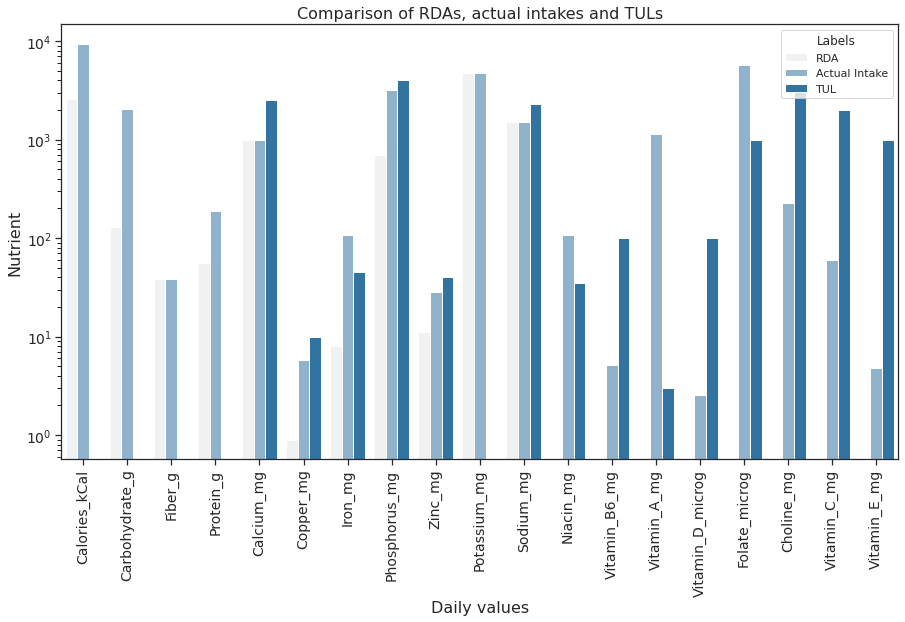

In [12]:
#@title Plot the RDAs, intakes and TULs for key nutrients
sns.set(style="ticks")  
df_to_plot = pd.melt(df_with_TUL, id_vars=['Nutrient'], \
                     value_vars=["RDA",	"Actual Intake",	"TUL"], \
                     var_name='Labels', value_name='Values')

f, ax = plt.subplots(figsize=(15, 8))

# use next two lines if you prefer horizontal orientation instead of vertical
#ax.set_xscale("log")  
#sns.barplot(y="Nutrient", x="Values", hue="Labels", data=df_to_plot, orient="h")

ax.set_yscale("log")  
sns.barplot(x="Nutrient", y="Values", hue="Labels", data=df_to_plot, orient="v",\
            color="tab:blue")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.set_ylabel('Nutrient',fontsize=16)
ax.set_xlabel('Daily values',fontsize=16)
ax.tick_params(axis='both', labelsize=14)
f = ax.set_title('Comparison of RDAs, actual intakes and TULs', fontsize=16)

____________

# **Q3**. 

Design a minimal-cost diet that also meets all the tolerable upper limits (TUL).

*This section assumes that you have already run all the sections before. If that is not the case, please re-run everything above, e.g., by selecting this cell and choosing **Runtime > Run before**.*

In [13]:
#@title Create an optimization model like in **Q1**, but with TUL constraints

# an empty model
myModel_Q3 = LpProblem(name="Optimal_Diet_Problem_Q3", sense=LpMinimize)

# decision variables
quantity_consumed_Q3 = LpVariable.dicts(name="Food_Q3",\
                                     indexs=all_foods,\
                                     lowBound=0.0, upBound=None,\
                                     cat="Continuous")

# calculate the objective and add it into the model
cost_Q3 = lpSum( quantity_consumed[f]*foodData["Price_($)"][f] for f in all_foods)
myModel_Q3 += cost

# constraints for all the RDAs
for n in nutrients_with_RDA :
    constraint = LpConstraint( lpSum(quantity_consumed_Q3[f]*foodData[n][f] for f in all_foods), 
                              sense = LpConstraintGE, \
                              rhs = RDA[n][Marco_life_stage], \
                              name = "RDA_{}".format(n) )
    myModel_Q3 += constraint

# add constraints for tolerable upper limits (TUL)
for n in nutrients_with_TUL:
    constraint = LpConstraint( lpSum(quantity_consumed_Q3[f]*foodData[n][f] for f in all_foods), 
                              sense = LpConstraintLE, \
                              rhs = TUL[n][Marco_life_stage], \
                              name = "TUL_{}".format(n) )
    myModel_Q3 += constraint


# if we want, print out the optimization model
# print(myModel)

print("Done creating the model.")
print("Proceeding to solve...")

# small 'hack' : we will store the model in a local directory to make sure there are no problems with duplicate models
#local_dir_Q3 = new_local_directory("Q3")
#solver = pulp.PULP_CBC_CMD(keepFiles=True)
#solver.tmpDir = local_dir_Q3

status = myModel_Q3.solve()
print("Status of the optimization: " + format(LpStatus[status]))

Done creating the model.
Proceeding to solve...
Status of the optimization: Infeasible


__Surprisingly, the output above informs us that the model is <font color=red>infeasible</font>__. In other words, there is no possible combination of foods that simultaneously satisfies all the constraints that we added (RDAs and TULs). When using certain powerful solver packages such as [Gurobi](https://www.gurobi.com/) or [IBM ilog CPLEX](https://www.ibm.com/products/ilog-cplex-optimization-studio), it is possible to calculate and display a small set of constraints that together make the model infeasible. You can actually obtain a **free, complete Gurobi license while registered as a student**, so you can try this out. Unfortunately, we cannot use Gurobi within Colab, so you would need to download the file and run it locally on your own machine. If you are interested in details, send an email to the instructor.

# **Q4**
Examine a few ways to resolve the problems we encountered in **Q3**.

Since the optimization problem in **Q3** is infeasible, the only way to resolve the issue is by relaxing or removing a few of the constraints. The code below explores a few different options.

In [14]:
#@title Select which constraints to **remove** from the model by ticking the boxes below:

# an empty model
myModel_Q4 = LpProblem(name="Optimal_Diet_Problem_Q4", sense=LpMinimize)

# decision variables
quantity_consumed_Q4 = LpVariable.dicts(name="Food_Q4",\
                                     indexs=all_foods,\
                                     lowBound=0.0, upBound=None,\
                                     cat="Continuous")

# calculate the objective and add it into the model
cost_Q4 = lpSum( quantity_consumed_Q4[f]*foodData["Price_($)"][f] for f in all_foods)
myModel_Q4 += cost

remove_RDA = {}

#@markdown <br> **RDA (recommended dietary allowances) constraints**:
remove_all_RDA = False #@param {type:"boolean"}
remove_RDA_Calories = False #@param {type:"boolean"}
remove_RDA_Carbohydrate = False #@param {type:"boolean"}
remove_RDA_Fiber = False #@param {type:"boolean"}
remove_RDA_Protein = False #@param {type:"boolean"}
remove_RDA_Calcium = False #@param {type:"boolean"}
remove_RDA_Copper = False #@param {type:"boolean"}
remove_RDA_Iron = False #@param {type:"boolean"}
remove_RDA_Phosphorus = False #@param {type:"boolean"}
remove_RDA_Zinc = False #@param {type:"boolean"}
remove_RDA_Potassium = False #@param {type:"boolean"}
remove_RDA_Sodium = False #@param {type:"boolean"}

remove_TUL = {}
#@markdown <br>**TUL (tolerable upper limit) constraints:**
remove_all_TUL = False #@param {type:"boolean"}
remove_TUL_Calcium = False #@param {type:"boolean"}
remove_TUL_Copper = False #@param {type:"boolean"}
remove_TUL_Iron = False #@param {type:"boolean"}
remove_TUL_Phosphorus = False #@param {type:"boolean"}
remove_TUL_Zinc = False #@param {type:"boolean"}
remove_TUL_Sodium = False #@param {type:"boolean"}
remove_TUL_Vitamin_A = True #@param {type:"boolean"}
remove_TUL_Vitamin_C = False #@param {type:"boolean"}
remove_TUL_Vitamin_D = False #@param {type:"boolean"}
remove_TUL_Vitamin_E = False #@param {type:"boolean"}
remove_TUL_Niacin = False #@param {type:"boolean"}
remove_TUL_Vitamin_B6 = False #@param {type:"boolean"}
remove_TUL_Folate = False #@param {type:"boolean"}
remove_TUL_Choline = False #@param {type:"boolean"}

# constraints for all the RDAs
for n in nutrients_with_RDA :
    if remove_all_RDA==False and (eval("remove_RDA_" + n.rsplit("_", maxsplit=1)[0])==False):
        constraint = LpConstraint( lpSum(quantity_consumed_Q4[f]*foodData[n][f] for f in all_foods), 
                                  sense = LpConstraintGE, \
                                  rhs = RDA[n][Marco_life_stage], \
                                  name = "RDA_{}".format(n) )
        myModel_Q4 += constraint

# add constraints for tolerable upper limits (TUL)
for n in nutrients_with_TUL:
    if remove_all_TUL==False and (eval("remove_TUL_" + n.rsplit("_", maxsplit=1)[0])==False):
        constraint = LpConstraint( lpSum(quantity_consumed_Q4[f]*foodData[n][f] for f in all_foods), 
                                  sense = LpConstraintLE, \
                                  rhs = TUL[n][Marco_life_stage], \
                                  name = "TUL_{}".format(n) )
        myModel_Q4 += constraint

# if we want, print out the optimization model
# print(myModel)

print("Done creating the model.")
print("Proceeding to solve...")

# solve the model and display the status
status = myModel_Q4.solve()
print("Status of the optimization: " + format(LpStatus[status]))

tol = 1e-4
tol_constraints = 1e-4

#@markdown If the problem is feasible, display information about the solution, comparing it with Q1
if LpStatus[status]=="Optimal":

    daily_RDA_vals = [RDA[n][Marco_life_stage] if n in nutrients_with_RDA else 0 \
                      for n in relevant_nutrients]
    daily_intake_vals_Q4 = [sum(quantity_consumed_Q4[f].varValue*foodData[n][f] \
                        for f in all_foods) for n in relevant_nutrients]
    daily_TUL_vals = [TUL[n][Marco_life_stage] if n in nutrients_with_TUL else np.Inf \
                      for n in relevant_nutrients]

    Q4_below_RDA = [ 100*(daily_intake_vals_Q4[i] / daily_RDA_vals[i] - 1.0) if \
                    daily_intake_vals_Q4[i] < daily_RDA_vals[i] - tol_constraints else 0 \
                  for i in range(len(relevant_nutrients)) ]

    Q4_exceed_TUL = [ 100*(daily_intake_vals_Q4[i] / daily_TUL_vals[i] - 1.0) if \
                    daily_intake_vals_Q4[i] > daily_TUL_vals[i] + tol_constraints else 0 \
                  for i in range(len(relevant_nutrients))]

    df_with_TUL_Q4 = pd.DataFrame.from_dict( {"Nutrient" : relevant_nutrients, \
                                              "RDA" : daily_RDA_vals,\
                                              "TUL" : daily_TUL_vals,\
                                              "Actual Intake in Q1" : daily_intake_vals_Q1,\
                                              "Actual Intake in Q4" : daily_intake_vals_Q4,\
                                              "Above TUL(%)" : Q4_exceed_TUL,\
                                              } )
    
    pd.set_option('display.max_rows', df_with_TUL_Q4.shape[0]+1)
    pd.set_option('display.max_columns', df_with_TUL_Q4.shape[1]+1)
    display(df_with_TUL_Q4)

Done creating the model.
Proceeding to solve...
Status of the optimization: Optimal


,Nutrient,RDA,TUL,Actual Intake in Q1,Actual Intake in Q4,Above TUL(%)
0,Calories_kCal,"2,600.00",inf,"9,322.76","2,847.13",0.00
1,Carbohydrate_g,130.00,inf,"2,037.18",463.00,0.00
2,Fiber_g,38.00,inf,38.00,38.00,0.00
3,Protein_g,56.00,inf,187.61,125.20,0.00
4,Calcium_mg,"1,000.00","2,500.00","1,000.00","2,500.00",0.00
5,Copper_mg,0.90,10.00,5.84,3.88,0.00
6,Iron_mg,8.00,45.00,107.47,28.05,0.00
7,Phosphorus_mg,700.00,"4,000.00","3,189.51","2,267.52",0.00
8,Zinc_mg,11.00,40.00,28.50,21.66,0.00
9,Potassium_mg,"4,700.00",inf,"4,700.00","5,754.89",0.00


In [15]:
#@title Select a tolerance (in %) by which to relax **all** the constraints (RDA and TUL):

# an empty model
myModel_Q4 = LpProblem(name="Optimal_Diet_Problem_Q4", sense=LpMinimize)

# decision variables
quantity_consumed_Q4 = LpVariable.dicts(name="Food_Q4",\
                                     indexs=all_foods,\
                                     lowBound=0.0, upBound=None,\
                                     cat="Continuous")

# calculate the objective and add it into the model
cost_Q4 = lpSum( quantity_consumed_Q4[f]*foodData["Price_($)"][f] for f in all_foods)
myModel_Q4 += cost

#@markdown <br> **RDA (recommended dietary allowances) constraints**:
tolerance_for_relaxing_constraints = 8 #@param {type:"number"}
tol = max(0,tolerance_for_relaxing_constraints/100)

# constraints for all the RDAs
for n in nutrients_with_RDA :
    constraint = LpConstraint( lpSum(quantity_consumed_Q4[f]*foodData[n][f] for f in all_foods), 
                              sense = LpConstraintGE, \
                              rhs = RDA[n][Marco_life_stage]*(1-tol), \
                              name = "RDA_{}".format(n) )
    myModel_Q4 += constraint

# add constraints for tolerable upper limits (TUL)
for n in nutrients_with_TUL:
    constraint = LpConstraint( lpSum(quantity_consumed_Q4[f]*foodData[n][f] for f in all_foods), 
                              sense = LpConstraintLE, \
                              rhs = TUL[n][Marco_life_stage]*(1+tol), \
                              name = "TUL_{}".format(n) )
    myModel_Q4 += constraint

# if we want, print out the optimization model
# print(myModel)

print("Done creating the model.")
print("Proceeding to solve...")

# solve the model and display the status
status = myModel_Q4.solve()
print("Status of the optimization: " + format(LpStatus[status]))

tol_constraints = 1e-4

#@markdown If the problem is feasible, display information about the solution, comparing it with Q1
if LpStatus[status]=="Optimal":

    daily_RDA_vals = [RDA[n][Marco_life_stage] if n in nutrients_with_RDA else 0 \
                      for n in relevant_nutrients]
    daily_intake_vals_Q4 = [sum(quantity_consumed_Q4[f].varValue*foodData[n][f] \
                        for f in all_foods) for n in relevant_nutrients]
    daily_TUL_vals = [TUL[n][Marco_life_stage] if n in nutrients_with_TUL else np.Inf \
                      for n in relevant_nutrients]

    Q4_below_RDA = [ 100*(daily_intake_vals_Q4[i] / daily_RDA_vals[i] - 1.0) if \
                    daily_intake_vals_Q4[i] < daily_RDA_vals[i] - tol_constraints else 0 \
                  for i in range(len(relevant_nutrients)) ]

    Q4_exceed_TUL = [ 100*(daily_intake_vals_Q4[i] / daily_TUL_vals[i] - 1.0) if \
                    daily_intake_vals_Q4[i] > daily_TUL_vals[i] + tol_constraints else 0 \
                  for i in range(len(relevant_nutrients))]

    df_with_TUL_Q4 = pd.DataFrame.from_dict( {"Nutrient" : relevant_nutrients, \
                                              "RDA" : daily_RDA_vals,\
                                              "TUL" : daily_TUL_vals,\
                                              "Actual Intake in Q4" : daily_intake_vals_Q4,\
                                              "Under RDA(%)" : Q4_below_RDA,\
                                              "Above TUL(%)" : Q4_exceed_TUL,\
                                              } )
    pd.set_option('display.max_rows', df_with_TUL_Q4.shape[0]+1)
    display(df_with_TUL_Q4)

Done creating the model.
Proceeding to solve...
Status of the optimization: Optimal


,Nutrient,RDA,TUL,Actual Intake in Q4,Under RDA(%),Above TUL(%)
0,Calories_kCal,"2,600.00",inf,"60,338.27",0.00,0.00
1,Carbohydrate_g,130.00,inf,138.26,0.00,0.00
2,Fiber_g,38.00,inf,34.96,-8.00,0.00
3,Protein_g,56.00,inf,79.81,0.00,0.00
4,Calcium_mg,"1,000.00","2,500.00",920.00,-8.00,0.00
5,Copper_mg,0.90,10.00,0.94,0.00,0.00
6,Iron_mg,8.00,45.00,48.60,0.00,8.00
7,Phosphorus_mg,700.00,"4,000.00","1,283.00",0.00,0.00
8,Zinc_mg,11.00,40.00,10.12,-8.00,0.00
9,Potassium_mg,"4,700.00",inf,"5,906.73",0.00,0.00


# **Q5**

Finding a diet that is as close as possible to Marco's diet, and does not exceed a daily budget of $5.

In [16]:
#@title Install a few additional modules needed here

# install pyomo and ipopt solver for Q5 
!pip install -q pyomo &> /dev/null # install pyomo
!apt-get install -y -qq glpk-utils # install GLPK solver for linear optimization
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64 
import pyomo.kernel as pmo
from pyomo.environ import *  

#### A Model with Squared Differences

We can start with a model that measures the difference in the diets using the sum of squared differences:
> $\sum_{f}$ (Recommended consumption of food $f$ - Current consumption of food $f$)$^2$


Square root of total difference from Marco's diet (in grams): 480.154.

 Food                                  Name  Old Diet  New Diet
    2                     CHEESE, CAMEMBERT    100.00      0.00
    7         MILK,RED FAT,FLUID,2% MILKFAT      0.00     32.51
    8          MILK,LOWFAT,FLUID,1% MILKFAT      0.00     34.76
   10                MILK SHAKES,THICK CHOC      0.00     19.64
   12                 YOGURT, FRUIT, LOWFAT    150.00     81.67
   14               EGG, WHITE ONLY, COOKED    200.00    104.95
   17                        DULCE DE LECHE     20.00    125.97
   24  OIL,SUNFLOWER,LINOLEIC,(APPROX. 65%)      0.00      9.71
   25              MARGARINE, STICK, SALTED      0.00     38.37
   31         CHICKEN BREAST  OVEN-ROASTED     250.00      0.00
   32                              ALL-BRAN      0.00    154.26
   34                            APPLE, RAW     50.00      0.00
   36                           BANANA, RAW      0.00     88.78
   37                          

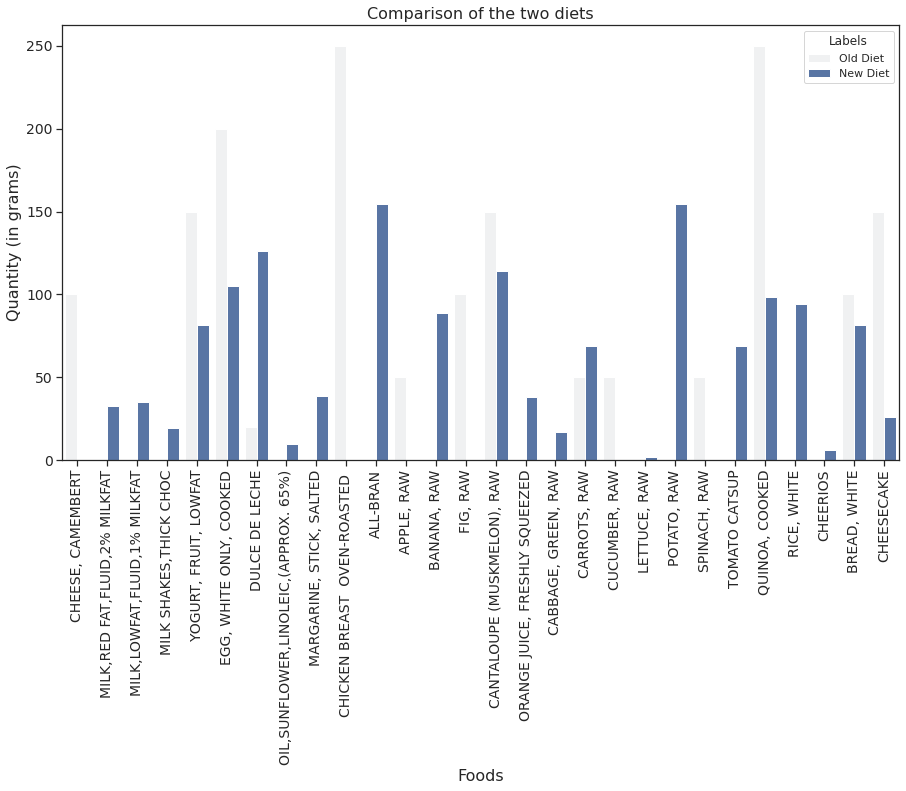

In [17]:
#@title Construct a model that recommends a "close" diet
daily_Budget = 5 # daily budget of $5 

myModel = ConcreteModel("Optimal Diet Problem")
myModel.quantity_consumed = Var(all_foods, domain=NonNegativeReals, name = "Food")

# calculate the cost
total_difference = sum((myModel.quantity_consumed[f] - foodData["Marco_Diet"][f])**2 for f in all_foods)
myModel.objective = Objective(expr=total_difference, sense=minimize)

# Add constraints for each nutrient that has an RDA specified; we will name the constraint using the nutrient name
myModel.RDA_Constraints=ConstraintList()
for n in nutrients_with_RDA:
  myModel.RDA_Constraints.add(expr=sum(myModel.quantity_consumed[f]*foodData[n][f] for f in all_foods ) \
                      >= RDA[n][Marco_life_stage])
  
cost = sum( myModel.quantity_consumed[f]*foodData["Price_($)"][f] for f in all_foods)
myModel.budget=Constraint( expr=cost <= daily_Budget )

opt = SolverFactory('ipopt')
opt.solve(myModel)

tol = 0.001   # tolerance: if the diet includes an amount LESS than this, we won't count it in!

foods_with_differences = []
names_foods_with_differences = []
new_diet_values = []
old_diet_values = []

print("\nSquare root of total difference from Marco's diet (in grams): {:.3f}.\n".\
      format(100*np.sqrt(myModel.objective())))
for f in all_foods:
  if (value(myModel.quantity_consumed[f]) > tol) or (foodData["Marco_Diet"][f] > tol) :
     foods_with_differences += [f]
     names_foods_with_differences += [foodData["Main_food_description"][f]]
     new_diet_values += [value(myModel.quantity_consumed[f])*100]
     old_diet_values += [foodData["Marco_Diet"][f]*100]

df_differences_Q5 = pd.DataFrame.from_dict( {"Food" : foods_with_differences, \
                                             "Name" : names_foods_with_differences,\
                                             "Old Diet" : old_diet_values,\
                                             "New Diet" : new_diet_values
                                             } )
# print the dataframe
pd.set_option('display.max_rows', df_differences_Q5.shape[0]+1)
print(df_differences_Q5.to_string(index=False))

#@markdown Plot the foods with differences in the old and new diets
sns.set(style="ticks")  
df_to_plot = pd.melt(df_differences_Q5, id_vars=['Food', "Name"], \
                     value_vars=["Old Diet",	"New Diet"], \
                     var_name='Labels', value_name='Values')

f, ax = plt.subplots(figsize=(15, 8))

# use next two lines if you prefer horizontal orientation instead of vertical
#ax.set_xscale("log")  
#sns.barplot(y="Nutrient", x="Values", hue="Labels", data=df_to_plot, orient="h")

sns.barplot(x="Name", y="Values", hue="Labels", data=df_to_plot, orient="v",\
            color="b")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.set_ylabel('Quantity (in grams)',fontsize=16)
ax.set_xlabel('Foods',fontsize=16)
ax.tick_params(axis='both', labelsize=14)
f = ax.set_title('Comparison of the two diets', fontsize=16)

#### A Model with Absolute Differences

We can start with a model that measures the difference in the diets using the sum of squared differences:
> $\sum_{f}$ | Recommended consumption of food $f$ - Current consumption of food $f$|


Absolute total difference from Marco's diet (in grams): 390.184. 
 Food                           Name  Old Diet  New Diet
    2              CHEESE, CAMEMBERT    100.00      0.00
   12          YOGURT, FRUIT, LOWFAT    150.00    150.00
   14        EGG, WHITE ONLY, COOKED    200.00    200.00
   17                 DULCE DE LECHE     20.00     20.00
   31  CHICKEN BREAST  OVEN-ROASTED     250.00      0.00
   32                       ALL-BRAN      0.00     53.39
   34                     APPLE, RAW     50.00     50.00
   37                       FIG, RAW    100.00      0.00
   40    CANTALOUPE (MUSKMELON), RAW    150.00    150.00
   45                   CARROTS, RAW     50.00     50.00
   49                  CUCUMBER, RAW     50.00     50.00
   54                    POTATO, RAW      0.00    550.63
   55                   SPINACH, RAW     50.00     15.84
   61                 QUINOA, COOKED    250.00      0.00
   63                    RICE, WHITE      0.00    184.27
   65                

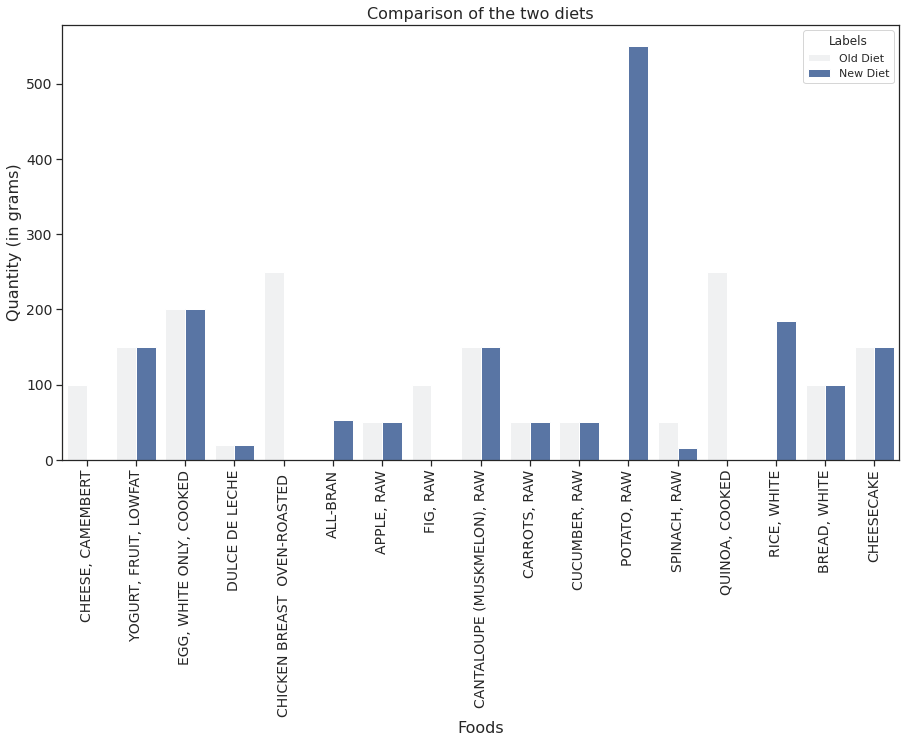

In [18]:
#@title Construct a model that recommendas a "close" diet
daily_Budget = 5 # daily budget of $5 

myModel = ConcreteModel("Optimal Diet Problem")
myModel.quantity_consumed = Var(all_foods, domain=NonNegativeReals, name = "Food")

# auxiliary variables for absolute differences
myModel.abs_differences = Var(all_foods)

myModel.cons1=ConstraintList()
myModel.cons2=ConstraintList()

for f in all_foods:
    myModel.cons1.add( expr= myModel.abs_differences[f] >= myModel.quantity_consumed[f] - foodData["Marco_Diet"][f] )
    myModel.cons2.add( expr= myModel.abs_differences[f] >= foodData["Marco_Diet"][f] - myModel.quantity_consumed[f] )

# calculate the total difference in diets and set as objective
myModel.objective=Objective( expr=sum(myModel.abs_differences[f] for f in all_foods), sense=minimize)

# Add constraints for each nutrient that has an RDA specified; we will name the constraint using the nutrient name
myModel.RDA_Constraints=ConstraintList()
for n in nutrients_with_RDA:
  myModel.RDA_Constraints.add(expr=sum(myModel.quantity_consumed[f]*foodData[n][f] for f in all_foods ) \
                      >= RDA[n][Marco_life_stage])
  
cost = sum( myModel.quantity_consumed[f]*foodData["Price_($)"][f] for f in all_foods)
myModel.budget=Constraint( expr=cost <= daily_Budget )

opt = SolverFactory('ipopt')
opt.solve(myModel)

tol = 0.0000001   # tolerance: if the diet includes an amount LESS than this, we won't count it in!

foods_with_differences = []
names_foods_with_differences = []
new_diet_values = []
old_diet_values = []

print("\nAbsolute total difference from Marco's diet (in grams): {:.3f}. ".\
      format(100*np.sqrt(myModel.objective())))
for f in all_foods:
  if (value(myModel.quantity_consumed[f]) > tol) or (foodData["Marco_Diet"][f] > tol) :
     foods_with_differences += [f]
     names_foods_with_differences += [foodData["Main_food_description"][f]]
     new_diet_values += [value(myModel.quantity_consumed[f])*100]
     old_diet_values += [foodData["Marco_Diet"][f]*100]

df_differences_Q5 = pd.DataFrame.from_dict( {"Food" : foods_with_differences, \
                                             "Name" : names_foods_with_differences,\
                                             "Old Diet" : old_diet_values,\
                                             "New Diet" : new_diet_values
                                             } )

# print the dataframe
pd.set_option('display.max_rows', df_differences_Q5.shape[0]+1)
print(df_differences_Q5.to_string(index=False))

#@markdown Plot the foods with differences in the old and new diets
sns.set(style="ticks")  
df_to_plot = pd.melt(df_differences_Q5, id_vars=['Food', "Name"], \
                     value_vars=["Old Diet",	"New Diet"], \
                     var_name='Labels', value_name='Values')

f, ax = plt.subplots(figsize=(15, 8))

# use next two lines if you prefer horizontal orientation instead of vertical
#ax.set_xscale("log")  
#sns.barplot(y="Nutrient", x="Values", hue="Labels", data=df_to_plot, orient="h")

sns.barplot(x="Name", y="Values", hue="Labels", data=df_to_plot, orient="v",\
            color="b")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.set_ylabel('Quantity (in grams)',fontsize=16)
ax.set_xlabel('Foods',fontsize=16)
ax.tick_params(axis='both', labelsize=14)
f = ax.set_title('Comparison of the two diets', fontsize=16)